<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/6_ChatBot/Transformer_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 작업 공간 접근

In [1]:
ls

drive/  sample_data/


In [2]:
cd drive/MyDrive/ChatBot_Transformer/

/content/drive/MyDrive/ChatBot_Transformer


In [3]:
ls

data_in/          preprocess.py        __pycache__/
Preprocess.ipynb  preprocess_py.ipynb  Transformer_ChatBot.ipynb


### Konlpy 설치

In [4]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.com/ubuntu b

In [5]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [6]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists...
Reading 

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   936k      0  0:00:01  0:00:01 --:--:-- 1753k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

# 모듈 불러오기

In [7]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [8]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로

In [9]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [10]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 불러오기

In [11]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 하이퍼파라미터 정의

In [12]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

# 모델

## 마스킹

In [14]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len) # Numpy Broadcasting을 위한 차원 확장

In [15]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [16]:
def create_masks(inp, tar):
    # 인코더 패딩 마스크
    enc_padding_mask = create_padding_mask(inp)

    # 디코더에서 2번째 멀티헤드어텐션에서 사용하는 패딩 마스크 (인코더 단어들에 대한 패딩)
    dec_padding_mask = create_padding_mask(inp)

    # 디코더 1번째 멀티헤드어텐션에서 사용하는 마스크 (디코더 단어들에 대한 패딩 마스크 + 미래 참조를 막는 마스크)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # tf.maximum을 통한 (디코더 단어들에 대한 패딩 마스크 + 미래 참조를 막는 마스크)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [17]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

## 포지셔널 인코딩

In [18]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


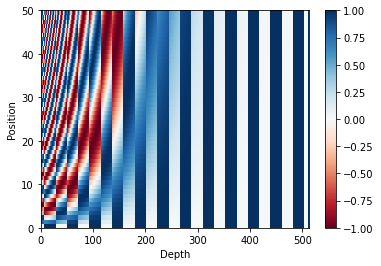

In [30]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu') #컬러 : Red&Blue
plt.xlabel('Depth')
plt.xlim((0, 512)) # d_model의 차원=512
plt.ylabel('Position')
plt.colorbar() # 칼라바(우측) 표시
plt.show()

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# TEST

### mask

In [ ]:
import tensorflow as tf

In [ ]:
b=1-tf.linalg.band_part(tf.ones((2,2)),-1,0)

In [ ]:
b*-1e9

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.e+00, -1.e+09],
       [-0.e+00, -0.e+00]], dtype=float32)>

In [ ]:
import numpy as np

In [ ]:
a=np.array([[1,2],[3,4]])

In [ ]:
a+=b*-1e9

In [ ]:
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.e+00, -1.e+09],
       [ 3.e+00,  4.e+00]], dtype=float32)>

### tf.matamul

In [ ]:
a=np.array([[[[1,2,3],[3,4,5]],[[5,6,7],[7,8,9]]],[[[1,2,3],[3,4,5]],[[5,6,7],[7,8,9]]]])

In [ ]:
a.shape

(2, 2, 2, 3)

In [ ]:
tf.matmul(a,a,transpose_b=True)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 14,  26],
         [ 26,  50]],

        [[110, 146],
         [146, 194]]],


       [[[ 14,  26],
         [ 26,  50]],

        [[110, 146],
         [146, 194]]]])>

### tf.reshape & tf.transpose  (4차원)

In [ ]:
a = np.array([[[1,2,3,4],[4,5,6,7]],[[7,8,9,10],[10,11,12,13]]])
a

array([[[ 1,  2,  3,  4],
        [ 4,  5,  6,  7]],

       [[ 7,  8,  9, 10],
        [10, 11, 12, 13]]])

In [ ]:
b=tf.reshape(a,(2,-1,2,2))
b

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 3,  4]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 7,  8],
         [ 9, 10]],

        [[10, 11],
         [12, 13]]]])>

In [ ]:
tf.transpose(b) # perm = [3,2,1,0]

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  7],
         [ 4, 10]],

        [[ 3,  9],
         [ 6, 12]]],


       [[[ 2,  8],
         [ 5, 11]],

        [[ 4, 10],
         [ 7, 13]]]])>

In [ ]:
tf.transpose(b,[0,2,1,3])

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 4,  5]],

        [[ 3,  4],
         [ 6,  7]]],


       [[[ 7,  8],
         [10, 11]],

        [[ 9, 10],
         [12, 13]]]])>

In [ ]:
tf.transpose(b,[3,1,2,0])

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  7],
         [ 3,  9]],

        [[ 4, 10],
         [ 6, 12]]],


       [[[ 2,  8],
         [ 4, 10]],

        [[ 5, 11],
         [ 7, 13]]]])>

In [ ]:
tf.reshape(a,(2,2,-1,2))

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 3,  4]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 7,  8],
         [ 9, 10]],

        [[10, 11],
         [12, 13]]]])>

In [ ]:
x = tf.constant([[[ 1,  2,  3],
                  [ 4,  5,  6]],
                 [[ 7,  8,  9],
                  [10, 11, 12]]])

In [ ]:
x

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x) #perm=[2,1,0]

<tf.Tensor: shape=(3, 2, 2), dtype=int32, numpy=
array([[[ 1,  7],
        [ 4, 10]],

       [[ 2,  8],
        [ 5, 11]],

       [[ 3,  9],
        [ 6, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x,perm=[1,2,0])

<tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
array([[[ 1,  7],
        [ 2,  8],
        [ 3,  9]],

       [[ 4, 10],
        [ 5, 11],
        [ 6, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x,perm=[2,0,1])

<tf.Tensor: shape=(3, 2, 2), dtype=int32, numpy=
array([[[ 1,  4],
        [ 7, 10]],

       [[ 2,  5],
        [ 8, 11]],

       [[ 3,  6],
        [ 9, 12]]], dtype=int32)>

In [ ]:
a=np.array([[1,2,3],[4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tf.transpose(a) # perm = [1,0]

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]])>

perm의 해당 차원(axis)에 따른 연산 횟수(이어붙이기)가, 새로 만들어지는 행렬의 행 차원이 될 것이므로, 현재 차원이 perm의 위치에 따라 적절하게 변하다.

perm의 마지막 axis부터 차례대로 뒷 차원부터 쌓여서 결과가 나올텐데,
각 차원에 해당하는 이어붙이기 개수가 그 차워의 개수가 될 것이므로,\
차원이 우리가 원하는 대로 변형된다.

### list의 [...]

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
a=np.array([[1,2,3],[4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
a[...]

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
a[np.newaxis,...]

array([[[1, 2, 3],
        [4, 5, 6]]])

In [ ]:
a[...,np.newaxis]

array([[[1],
        [2],
        [3]],

       [[4],
        [5],
        [6]]])

### BroadCastiing numpy

In [ ]:
a=np.array([[[1,2,3],[4,5,6]]]) 
print(a.shape)
b=np.array([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]]) 
print(b.shape)
b+a

(1, 2, 3)
(2, 2, 3)


array([[[ 2,  4,  6],
        [ 8, 10, 12]],

       [[ 8, 10, 12],
        [14, 16, 18]]])

In [ ]:
a=tf.cast(np.array([[False,True,True],[False,False,True]]),tf.float32) # 2 x 3
c=a[:,None,None,:] # 2 x 1 x 1 x 3

In [ ]:
c

<tf.Tensor: shape=(2, 1, 1, 3), dtype=float32, numpy=
array([[[[0., 1., 1.]]],


       [[[0., 0., 1.]]]], dtype=float32)>

In [ ]:
b=np.array([[0,1,1],[0,0,1],[0,0,0]])
tf.maximum(c,b)

<tf.Tensor: shape=(2, 1, 3, 3), dtype=float32, numpy=
array([[[[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]]],


       [[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 1.]]]], dtype=float32)>

In [33]:
a=np.array([[[[1,2,3],[4,5,6],[7,8,9]],[[7,8,9],[10,11,12],[1,2,3]]],[[[1,2,3],[4,5,6],[7,8,9]],[[7,8,9],[10,11,12],[1,2,3]]]])

In [36]:
print(a.shape)
a

(2, 2, 3, 3)


array([[[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[ 7,  8,  9],
         [10, 11, 12],
         [ 1,  2,  3]]],


       [[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[ 7,  8,  9],
         [10, 11, 12],
         [ 1,  2,  3]]]])

In [40]:
mask=np.array([[[[0,0,-100]]],[[[0,-100,-100]]]])
print(mask.shape)
mask

(2, 1, 1, 3)


array([[[[   0,    0, -100]]],


       [[[   0, -100, -100]]]])

In [41]:
a+mask

array([[[[  1,   2, -97],
         [  4,   5, -94],
         [  7,   8, -91]],

        [[  7,   8, -91],
         [ 10,  11, -88],
         [  1,   2, -97]]],


       [[[  1, -98, -97],
         [  4, -95, -94],
         [  7, -92, -91]],

        [[  7, -92, -91],
         [ 10, -89, -88],
         [  1, -98, -97]]]])